# CNN Classifier Training Example

This notebook demonstrates a basic 4-layer CNN trained to classify spectra from galaxies and galaxies + SNe of several types within 2 weeks (plus/minus) of max light. In this notebook the classifier assumes we can work in the host rest frame.

Required software:
* TensorFlow2
* [desihub software](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop) (with usual dependencies).

Adding more spectral categories is straightforward.

In [3]:
from glob import glob

import pickle 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import platform

In [4]:
mpl.rc('font', size=14)

## Input Spectra

Input DESI spectra generated from the pickle notebook. Then divide them into training and test sets for the classifier.

In [5]:
with open('host_flux.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

In [6]:
with open('snia_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

In [7]:
with open('snib_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snib_flux = pickle.load(filehandle)

In [8]:
with open('snic_flux.data', 'rb') as filehandle:
    snic_flux = pickle.load(filehandle)

In [9]:
with open('sniin_flux.data', 'rb') as filehandle:
    sniin_flux = pickle.load(filehandle)

In [10]:
with open('sniip_flux.data', 'rb') as filehandle:
    sniip_flux = pickle.load(filehandle)

In [11]:
host_flux=np.asarray(host_flux)
snia_flux=np.asarray(snia_flux)
snib_flux=np.asarray(snib_flux)
snic_flux=np.asarray(snic_flux)
sniin_flux=np.asarray(sniin_flux)
sniip_flux=np.asarray(sniip_flux)

nhost, nylen, nxlen  = host_flux.shape
nsnia, nylen, nxlen  = snia_flux.shape
nsnib, nylen, nxlen  = snib_flux.shape
nsnic, nylen, nxlen  = snic_flux.shape
nsniin, nylen, nxlen = sniin_flux.shape
nsniip, nylen, nxlen = sniip_flux.shape
# nhost, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nbins
nhost, nsnia, nsnib, nsnic, nsniin, nsniip, nylen, nxlen

(9969, 9964, 9958, 8269, 9949, 9962, 79, 79)

### Set up Training Sets and Labels

0. "host" spectra based only on BGS templates
0. "snia" spectra based on BGS + SN Ia templates
0. "snib" spectra based on BGS + SN Ib templates
0. "snic" spectra based on BGS + SN Ic templates
0. "sniin" spectra based on BGS + SN IIn templates
0. "sniip" spectra based on BGS + SN IIP templates

In [12]:
x = np.concatenate([host_flux, 
                    snia_flux,
                    snib_flux,
                    snic_flux,
                    sniin_flux,
                    sniip_flux
                   ]).reshape(-1,nylen, nxlen, 1)

labels = ['Host',
          'SN Ia',
          'SN Ib',
          'SN Ic',
          'SN IIn',
          'SN IIP']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nhost, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnic, 3),
                        np.full(nsniin, 4),
                        np.full(nsniip, 5)
                       ]))

In [13]:
x.shape, y.shape

((58071, 79, 79, 1), (58071, 6))

### Plot Image to check output

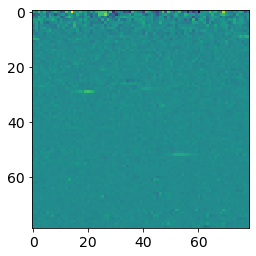

In [14]:
check=host_flux[0]
plt.imshow(check)
plt.show()

## CNN Network Setup

Train network with TensorFlow+Keras.

In [15]:
#import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate

In [85]:
def network( ncat,input_shape=(79,79,1), learning_rate=1.8225460564333567e-03, reg=0.05, dropout=0.7, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
   
    
    
    visible = Input(input_shape, name='Input_Spec1')

    # first feature extractor
    conv1 = Conv2D(24, kernel_size=3, activation='relu')(visible)
    #X = BatchNormalization(axis=2)(conv1)
    pool1 = MaxPooling2D(pool_size=(3, 3))(conv1)
    flat1 = Flatten()(pool1)
    
    # second feature extractor
    conv2 = Conv2D(24, kernel_size=9, activation='relu')(visible)
    #X2 = BatchNormalization(axis=2)(conv2)
    pool2 = MaxPooling2D(pool_size=(3, 3))(conv2)
    #conv21=Conv2D(32, kernel_size=8, activation='relu')(pool2)
    flat2 = Flatten()(conv2)
    
    # third feature extractor
    conv3 = Conv2D(24, kernel_size=15, activation='relu')(visible)
    #X3 = BatchNormalization(axis=2)(conv3)
    pool3 = MaxPooling2D(pool_size=(3, 3))(conv3)
    flat3 = Flatten()(pool3)
    
    # Fourth feature extractor
    conv4 = Conv2D(24, kernel_size=27, activation='relu')(visible)
    #X4 = BatchNormalization(axis=2)(conv4)
    pool4 = MaxPooling2D(pool_size=(3, 3))(conv4)
    flat4 = Flatten()(pool4)
    
    # Fifth feature extractor
    conv5 = Conv2D(24, kernel_size=39, activation='relu')(visible)
    #X4 = BatchNormalization(axis=2)(conv4)
    pool5 = MaxPooling2D(pool_size=(3, 3))(conv5)
    flat5 = Flatten()(pool5)
    

    
    # merge feature extractors
    merge = concatenate([flat1, flat2,flat3,flat4,flat5])
    
    # interpretation layer
    hidden1 = Dense(123, activation='relu')(merge)
  
    
    # prediction output
    output = Dense(6, activation='softmax')(hidden1)
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [86]:
model = network(ncat=y.shape[1])

In [87]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Spec1 (InputLayer)        [(None, 79, 79, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 77, 77, 24)   240         Input_Spec1[0][0]                
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 65, 65, 24)   5424        Input_Spec1[0][0]                
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 53, 53, 24)   17520       Input_Spec1[0][0]                
___________________________________________________________________________________________

## Train and Test

Split the data into training and testing (+ validation) samples and fit the network weights.

In [88]:
from sklearn.model_selection import train_test_split

def train_test_validate(x, y, train_size=0.75, test_size=0.125, val_size=0.125):
    # Ensure proper normalization.
    if train_size + test_size + val_size != 1:
        norm = train_size + test_size + val_size
        train_size = train_size/norm
        test_size = test_size/norm
        val_size = val_size/norm
        print('Renormalized to train {:g}, test {:g}, and validate {:g}'.format(train_size, test_size, val_size))
        
    # Split into training and testing samples.
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_size)
    
    # Split off the validation sample from the test sample.
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size/(test_size+val_size))
    
    return x_train, x_test, x_val, y_train, y_test, y_val

In [89]:
x_train, x_test, x_val, y_train, y_test, y_val = train_test_validate(x, y, 0.6, 0.2, 0.2)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train.shape, x_test.shape, x_val.shape

((34842, 79, 79, 1), (11615, 79, 79, 1), (11614, 79, 79, 1))

In [90]:
hist = model.fit(x_train, y_train, batch_size=50, epochs=200, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/200
697/697 [==============================] - 288s 413ms/step - loss: 1.7904 - accuracy: 0.1703 - val_loss: 1.7893 - val_accuracy: 0.1737
Epoch 2/200
697/697 [==============================] - 282s 404ms/step - loss: 1.7900 - accuracy: 0.1710 - val_loss: 1.7893 - val_accuracy: 0.1718
Epoch 3/200
697/697 [==============================] - 283s 406ms/step - loss: 1.7900 - accuracy: 0.1729 - val_loss: 1.7894 - val_accuracy: 0.1671
Epoch 4/200
697/697 [==============================] - 282s 405ms/step - loss: 1.7899 - accuracy: 0.1736 - val_loss: 1.7894 - val_accuracy: 0.1671
Epoch 5/200
697/697 [==============================] - 277s 397ms/step - loss: 1.7899 - accuracy: 0.1723 - val_loss: 1.7894 - val_accuracy: 0.1671
Epoch 6/200
577/697 [=======================>......] - ETA: 44s - loss: 1.7899 - accuracy: 0.1728

KeyboardInterrupt: 

## Performance

### Loss and Accuracy

Plot loss and accuracy as a function of epoch.

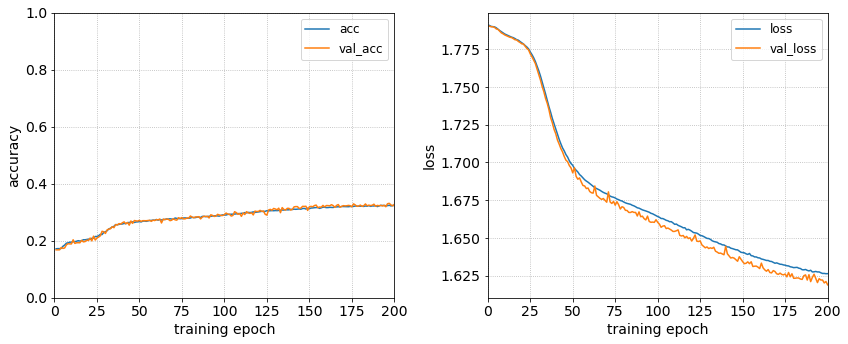

In [47]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();
fig.savefig('6label_acc_loss2.png', dpi=120)

### ROC Curve and Precision-Recall

Plot both the ROC curves per class and the class-averaged ROC curve.

In [78]:
y_pred = model.predict(x_val)
y_pred

array([[0.04407641, 0.0302099 , 0.03292921, 0.03705794, 0.00180075,
        0.08922195],
       [0.01857215, 0.08446831, 0.03192902, 0.02468714, 0.02519563,
        0.04242274],
       [0.01679081, 0.04653668, 0.02310038, 0.01695737, 0.03412762,
        0.04252663],
       ...,
       [0.04092866, 0.16309133, 0.07260415, 0.06850687, 0.01332849,
        0.07985681],
       [0.05381778, 0.14215496, 0.07439104, 0.06033972, 0.03201437,
        0.08751661],
       [0.0757232 , 0.02836341, 0.04750675, 0.05241117, 0.00330538,
        0.14344364]], dtype=float32)

In [1]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_val, y_pred)),
       aspect='equal')

fig.tight_layout()
fig.savefig('6label_roc_pr.png', dpi=120)

NameError: name 'plt' is not defined

### Class Activation Map
Map made with ScoreCam

In [40]:
from tf_keras_vis.scorecam import ScoreCAM

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

# The `output` variable refer to the output of the model,
def loss(output):

    return (output[0][6])



# Create ScoreCAM object
scorecam = ScoreCAM(model, model_modifier, clone=False)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(loss,
               x,
               penultimate_layer=-1, # model.layers number
               max_N=10
              )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(x[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



IndexError: index 6 is out of bounds for axis 0 with size 6

### Confusion Matrix

In [80]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

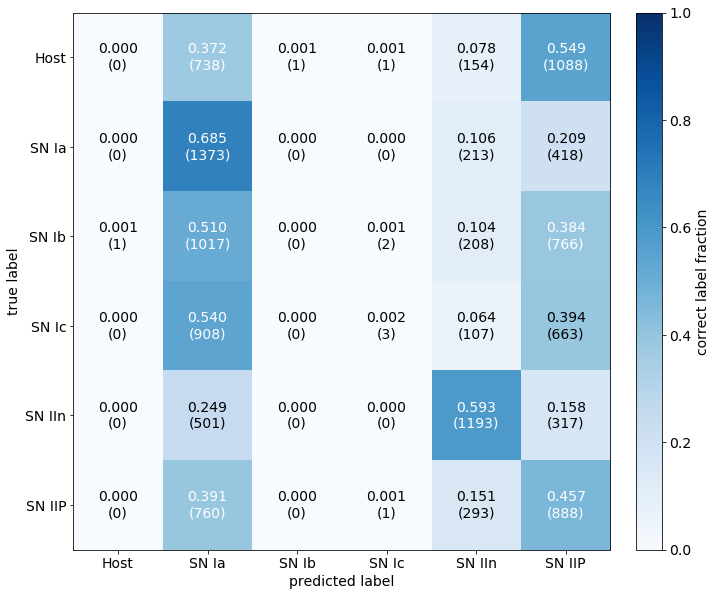

In [81]:
fig, ax = plt.subplots(1,1, figsize=(10,8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('6label_cm.png', dpi=120)

In [31]:
model.save('6label_cnn_restframe')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 6label_cnn_restframe/assets


In [32]:
model.save('6label_cnn_restframe.h5')

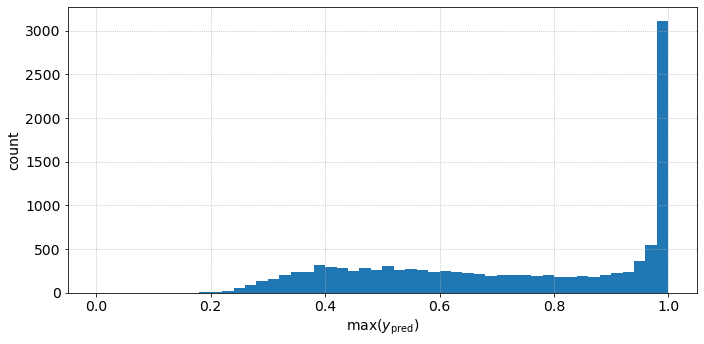

In [33]:
i = np.argmax(y_pred, axis=1)
y_max = np.max(y_pred, axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)
ax.hist(y_max, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count')
ax.grid(ls=':')
fig.savefig('max_ypred.png', dpi=120)

In [34]:
np.sum(y_max > 0.95) / len(y_max)

0.33175477871534353

In [35]:
select = y_max > 0.99

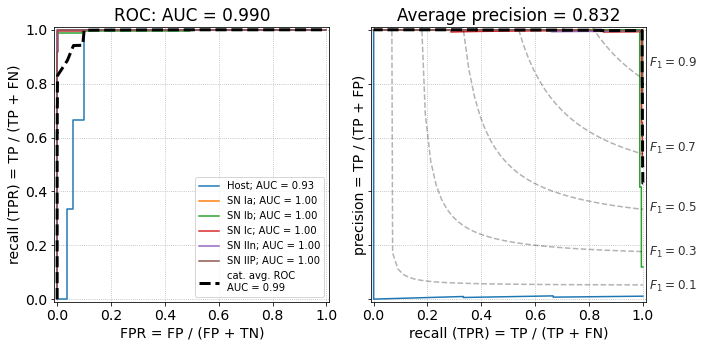

In [36]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[select][:,i], y_pred[select][:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[select][:,i], y_pred[select][:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val[select].ravel(), y_pred[select].ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_val[select], y_pred[select])),
       aspect='equal')

fig.tight_layout()
fig.savefig('6label_roc_pr_y99.png', dpi=120)

In [37]:
# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val[select].argmax(axis=1), y_pred[select].argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

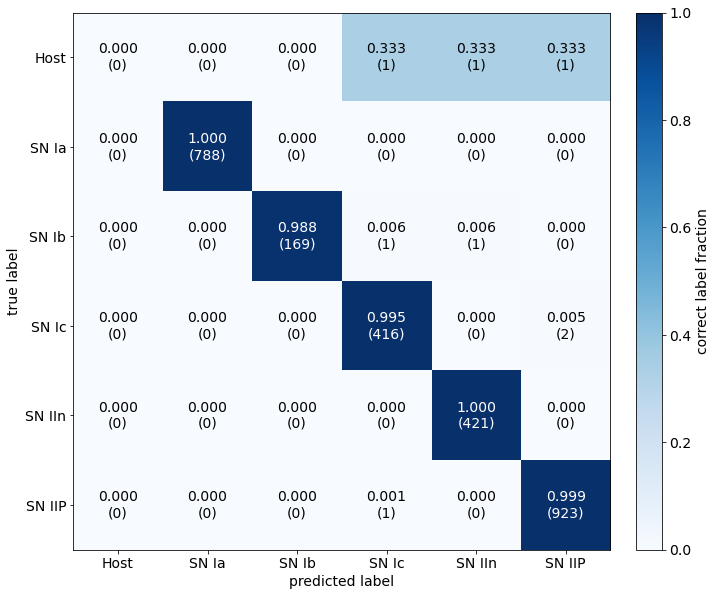

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10,8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

# thresh = 0.5*cm.max()
thresh = np.average(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('6label_cm_ygt0.99.png', dpi=120)

In [39]:
len(y_pred), len(y_pred) - np.sum(select)

(11614, 8889)